In [1]:
cd ..

/home/pierre/git/semisupervised


In [2]:
import numpy as np
from module.quadrature import Quadrature, QuadratureExploration, QuadratureExplorationBis
from botorch.models import SingleTaskGP
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

def plot_GP_fit(model, distribution, train_X, targets, obj, normalize=False, lb=-10., up=10., mean_Y=None, std_Y=None):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    
    if normalize:
        predictions = predictions*float(std_Y) + float(mean_Y)
        lower, upper = lower*float(std_Y), upper*float(std_Y)
        targets = targets*float(std_Y) + float(mean_Y)
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    y_lim = plt.gca().get_ylim()
    plt.plot(x, (y_lim[1] - y_lim[0])*stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten(), "k")
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot quadrature value and gradient in 1D case

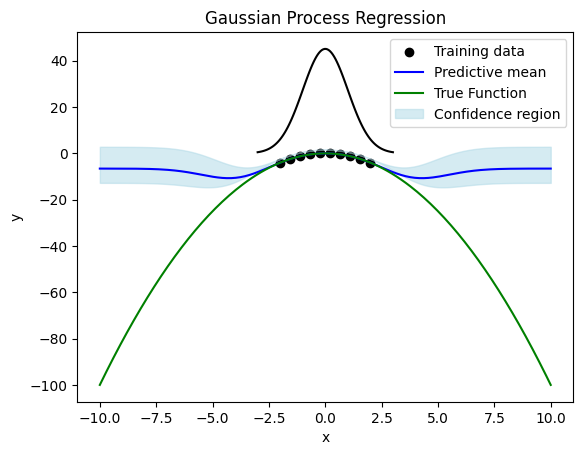

In [3]:
objective = lambda x: -x**2
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

mean_distrib, var_distrib = torch.tensor([0.]), torch.diag(torch.tensor([1.]))
quad_distrib = MultivariateNormal(mean_distrib, var_distrib)
NORMALIZE = True

n = 10
bounds = 2
lb, up= -10., 10.
train_X = torch.linspace(-bounds,bounds, n, dtype=torch.float64).reshape(-1,1)
train_Y = (objective(train_X)).sum(dim=1, keepdim=True)

if NORMALIZE:
    mean_Y = torch.mean(train_Y, dim = 0)
    std_Y = torch.std(train_Y, dim = 0)
    train_Y = (train_Y - mean_Y)/std_Y
else:
    mean_Y = None
    std_Y =None

# RBF kernel + training
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)


plot_GP_fit(model, quad_distrib, train_X, train_Y, objective, normalize=NORMALIZE, lb=lb, up=up, mean_Y=mean_Y, std_Y=std_Y)

In [4]:
quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50,
            maximize = True)
quad.quadrature()
quad.gradient_direction()

def posterior_quad(theta, var):
    mean_distrib_test, var_distrib_test = torch.tensor([theta], dtype=torch.float64), torch.diag(torch.tensor([var], dtype=torch.float64))
    quad_distrib_test = MultivariateNormal(mean_distrib_test, var_distrib_test)
    quad_test = Quadrature(model=model,
            distribution=quad_distrib_test,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50,
            maximize = True)
    
    quad_test.quadrature()
    return quad_test.m, quad_test.v

from scipy.stats import norm
def expected_improvement(theta, var, y_max, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    if var == 0.0:
            return 0.0
    
    with np.errstate(divide='warn'):
        imp = theta - y_max - xi
        Z = imp / var
        ei = imp * norm.cdf(Z) + var * norm.pdf(Z)
    return ei

/home/pierre/git/semisupervised/module/quadrature.py:53: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  self.m = self.model.mean_module.constant + (self.t_X.T @ torch.linalg.solve(self.K_X_X, self.model.train_targets - self.model.mean_module.constant))


In [5]:
b = np.arange(-15, 15, 0.1)
d = np.arange(0, 5, 0.05)[1:]**2
B, D = np.meshgrid(b, d)
n, m = b.shape[0], d.shape[0]
res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).numpy()
result, result_ei, result_wolfe = [], [], []
result_ei = []
for el in tqdm(res):
    post = posterior_quad(el[0], el[1])
    result.append(post)
    result_ei.append(expected_improvement(post[0].detach().numpy(), np.sqrt(post[1].detach().numpy()), torch.max(train_Y).numpy()))
    
mean, var = torch.tensor(result).numpy()[:,0].reshape(m,n), torch.tensor(result).numpy()[:,1].reshape(m,n)
ei = torch.tensor(result_ei).numpy().reshape(m,n)

100%|██████████| 29700/29700 [00:53<00:00, 553.61it/s]


In [6]:
t_linspace = torch.linspace(-0.5, 0.5, 200, dtype=train_X.dtype)
result_wolfe = []
for t in t_linspace:
    result_wolfe.append(quad.compute_p_wolfe(t))
wolfe_tensor = torch.tensor(result_wolfe)

/home/pierre/git/semisupervised/module/utils.py:380: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1615.)
  _ = torch.cholesky(B)


In [7]:
## Compute gradients at multiple places
b_grad = np.arange(-10, 10, 2)
d_grad = np.arange(0, 5, 1)[1:]**2
B_grad, D_grad = np.meshgrid(b_grad, d_grad)
n_grad, m_grad = b_grad.shape[0], d_grad.shape[0]
res_grad = torch.stack((torch.tensor(B_grad.flatten()), torch.tensor(D_grad.flatten())), axis = 1).numpy()
result_grad, max_length = [], 0
for el in tqdm(res_grad):
    mean_distrib_grad, var_distrib_grad = torch.tensor([el[0]], dtype=torch.float64), torch.diag(torch.tensor([el[1]], dtype=torch.float64))
    quad_distrib_grad = MultivariateNormal(mean_distrib_grad, var_distrib_grad)
    quad_grad = Quadrature(model=model,
            distribution=quad_distrib_grad,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 50,
            maximize = True)
    quad_grad.quadrature()
    quad_grad.gradient_direction()
    mu_grad, epsilon_grad = float(quad_grad.d_mu.detach().clone()), float(quad_grad.d_epsilon.detach().clone())
    max_length = max(max_length, np.sqrt(mu_grad**2 + epsilon_grad**2))
    result_grad.append([mu_grad, epsilon_grad])

100%|██████████| 40/40 [00:00<00:00, 249.23it/s]


40it [00:00, 1370.82it/s]


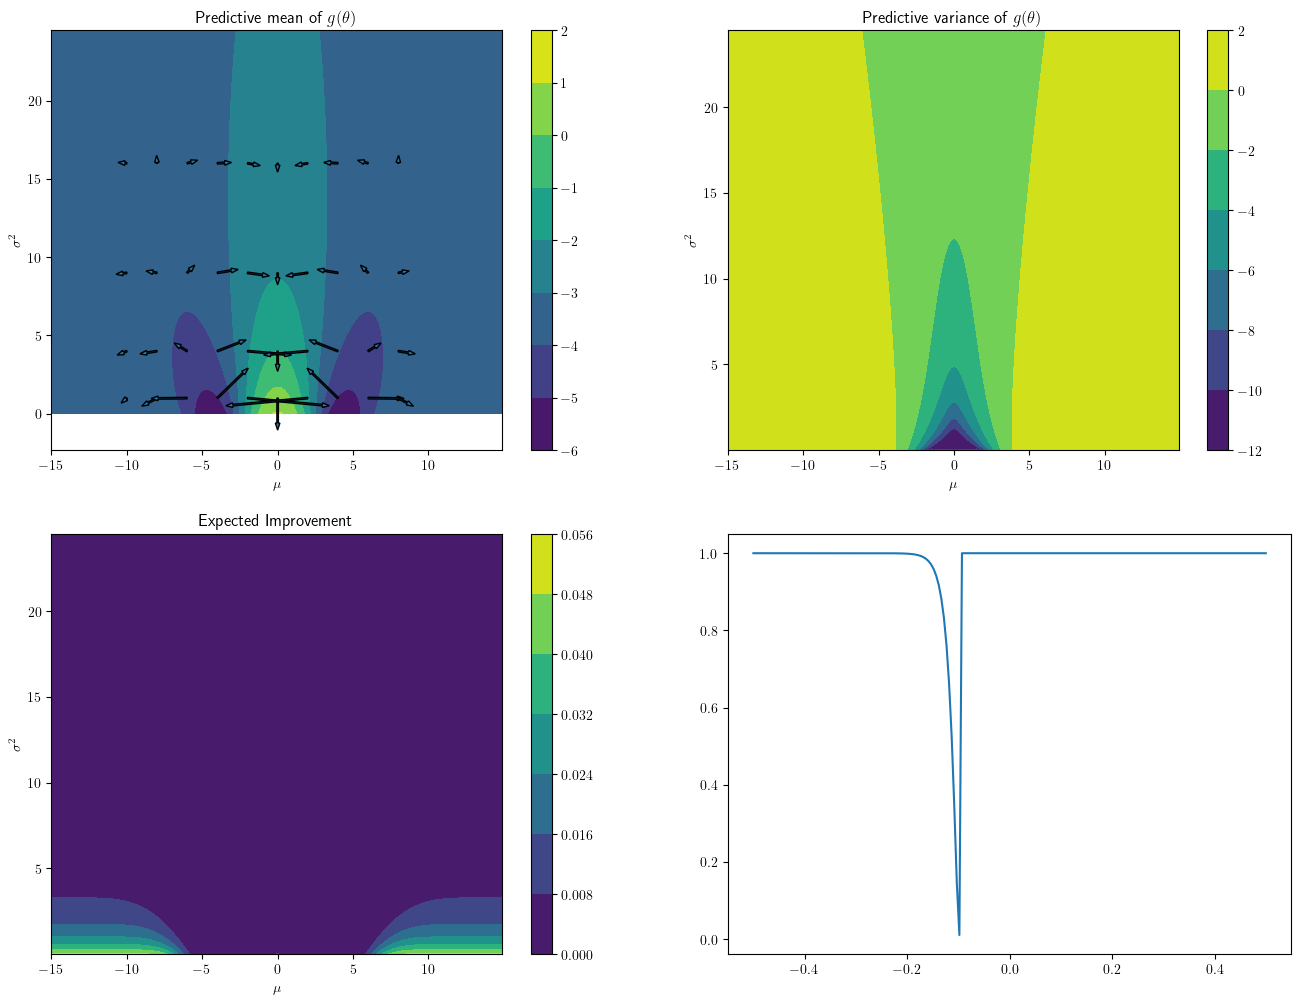

In [8]:
"""
Plot the following:
- Predictive mean and var of g(theta)
- Plot gradient of g(theta) at multiple places
- Plot (max) acquisition function?
- Plot wolfe condition given these plots
"""
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

contour1 = axs[0,0].contourf(B, D, mean)
# Gradient
max_length /= 5
for i, el in tqdm(enumerate(res_grad)):
    axs[0, 0].arrow(el[0], el[1], result_grad[i][0]/max_length, result_grad[i][1]/max_length, width = 0.1)
axs[0,0].set_xlabel(r'$\mu$')
axs[0,0].set_ylabel(r'$\sigma^{2}$')
axs[0,0].set_title(r"Predictive mean of $g(\theta)$")



contour2 = axs[0, 1].contourf(B, D, np.log(var))
axs[0, 1].set_xlabel(r'$\mu$')
axs[0, 1].set_ylabel(r'$\sigma^{2}$')
axs[0, 1].set_title(r"Predictive variance of $g(\theta)$")

contour3 = axs[1,0].contourf(B, D, ei)
axs[1,0].set_xlabel(r'$\mu$')
axs[1,0].set_ylabel(r'$\sigma^{2}$')
axs[1,0].set_title(r"Expected Improvement")

fig.colorbar(contour1, ax=axs[0,0])
fig.colorbar(contour2, ax=axs[0,1])
fig.colorbar(contour3, ax=axs[1,0])

axs[1,1].plot(t_linspace.numpy(), wolfe_tensor.numpy())

In [7]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior


quad_distrib = MultivariateNormal(torch.tensor([1.]), torch.diag(torch.tensor([1.])))
train_X = torch.linspace(-5,5, 20).reshape(-1,1)
train_Y = (-(train_X)**2).sum(dim=1, keepdim=True)
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 1,
            budget = 1000,
            maximize = True)

quad.gradient_direction(sample=False)
print("epsilon grad:", quad.d_epsilon)
print("mu grad:", quad.d_mu)

epsilon grad: tensor([[-232.6250]], grad_fn=<UnsafeViewBackward0>)
mu grad: tensor([-465.1659], grad_fn=<MvBackward0>)


/home/pierre/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


In [9]:
quad.t_max

tensor(0.0010)

In [8]:
quad.maximize_step()

In [10]:
quad.update_distribution()

MultivariateNormal(loc: tensor([0.5348], grad_fn=<ExpandBackward0>), covariance_matrix: tensor([[0.7674]], grad_fn=<ExpandBackward0>))